# Heart Disease (Cleveland)

# Introduction

Heart disease is a term used to describe a number of heart conditions, including a heart attack, an arrhythmia or heart failure. There are many symptoms for heart disease, specifically many symptoms that go unnoticed, and therefore at times it can be difficult to diagnose. What this project aims to do is to predict the presence of heart disease for a patient based on two numerical variables. We chose to use the Heart Disease dataset provided by the course, specifically the Cleveland segment. The variables that we found were the most accurate predictors were ST depression and maximum heart rate. Answering this question with these variables could signify a new way to predict heart disease using data, and possibly saving lives. 

# Preliminary exploratory data analysis

- [Demographics](#Demographics)
- [Summary of numerical variables](#Numerical-Variable)
- [Summary of categorial variables](#Categorial-Variable)

## 1. Reading and Wrangling Data 

### Load Libraries 

In [41]:
#Load required library
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

set.seed(8205)

 ## Reading in Heart Disease Data

- here, it is best to use URL since dataset can be read from the internet to enable reading without local file 
- column names were added for clarity 

In [42]:
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                           col_names = FALSE) |>
    rename(age      = X1,      # Age in years
           sex      = X2,      # Sex (1 = male, 0 = female)
           cp       = X3,      # Chest pain type 
                               # - 1 : typical angina
                               # - 2 : atypical angina
                               # - 3 : non-anginal pain
                               # - 4 : asymptomatic
           trestbps = X4,      # Resting blood pressure (mmHg)
           chol     = X5,      # Serum cholestoral (mg/dL)
           fbs      = X6,      # Fasting blood sugar > 120 mg/dL (1 = true, 0 = false)
           restecg  = X7,      # Resting electrocardiographic results 
                               # - 0 : normal,
                               # - 1 : having ST-T wave abnormality (T wave inversions and/or ST 
                               #       elevation or depression of > 0.05 mV)
                               # - 2 : showing probable or definite left ventricular hypertrophy by Estes' criteria
           thalach  = X8,      # Maximum heart rate achieved
           exang    = X9,      # Exercise induced angina (0 = no, 1 = yes)
           oldpeak  = X10,     # ST depression induced by exercise relative to rest
           slope    = X11,     # The slope of the peak exercise ST segment
                               # - 1 : upsloping
                               # - 2 : flat
                               # - 3 : downsloping
           ca       = X12,     # Number of major vessels (0-3) colored by flourosopy
           thal     = X13,     # 3 = normal; 6 = fixed defect; 7 = reversable defect
           num      = X14)     # diagnosis of heart disease (angiographic disease status)

cleveland_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


## Data wrangling

- categorical varaibles are mutated to factor as required by classificaiton.
- since we are predicting presence, a column of presence was added by mutating any number of heart disease class (num) above 0 represents presence

In [43]:
#Convert columns to sensible data types
cleveland_data <- cleveland_data |>
    mutate(age      = as.integer(age),
           sex      = as.factor(sex),
           cp       = as.factor(cp),
           trestbps = as.integer(trestbps),
           chol     = as.integer(chol),
           fbs      = as.factor(fbs),
           restecg  = as.factor(restecg),
           thalach  = as.double(thalach),
           exang    = as.factor(exang),
           oldpeak  = as.double(oldpeak),
           slope    = as.factor(slope),
           ca       = as.integer(ca),
           thal     = as.factor(thal),
           num      = as.factor(num)) 

# Creating a new column which is whether or not a person has presence of heart disease
cleveland_data <- cleveland_data |>
    mutate(presence = (num != 0)) |>    
    mutate(presence = as.factor(presence))


cleveland_data
print("Table 1: Heart Disease Variables (Cleveland Dataset)")

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,presence
<int>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6.0,0,FALSE
67,1,4,160,286,0,2,108,1,1.5,2,3,3.0,2,TRUE
67,1,4,120,229,0,2,129,1,2.6,2,2,7.0,1,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1,7.0,3,TRUE
57,0,2,130,236,0,2,174,0,0.0,2,1,3.0,1,TRUE
38,1,3,138,175,0,0,173,0,0.0,1,NA,3.0,0,FALSE


[1] "Table 1: Heart Disease Variables (Cleveland Dataset)"


## 3. Splitting Data 
- proportion of 75% of data assigned to the training dataset and 25% to 
- seed was used to ensure consistenly reproducible results despite randomness of initial_split()

In [44]:
# Splitting the data into training and testing sets
cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = num)
cleveland_training <- training(cleveland_split) 
cleveland_testing <- testing(cleveland_split)

### Summary of Dataset

In [45]:
target_summary <- cleveland_training |>
    group_by(presence) |>
    summarize(count = n())
target_summary
print("Table 2: Summary of Presence (or not) of Heart Disease and how many patients")

presence,count
<fct>,<int>
FALSE,123
TRUE,103


[1] "Table 2: Summary of Presence (or not) of Heart Disease and how many patients"


[1] "Figure 1: Summary of Presence (or not) of Heart Disease and how many patients"


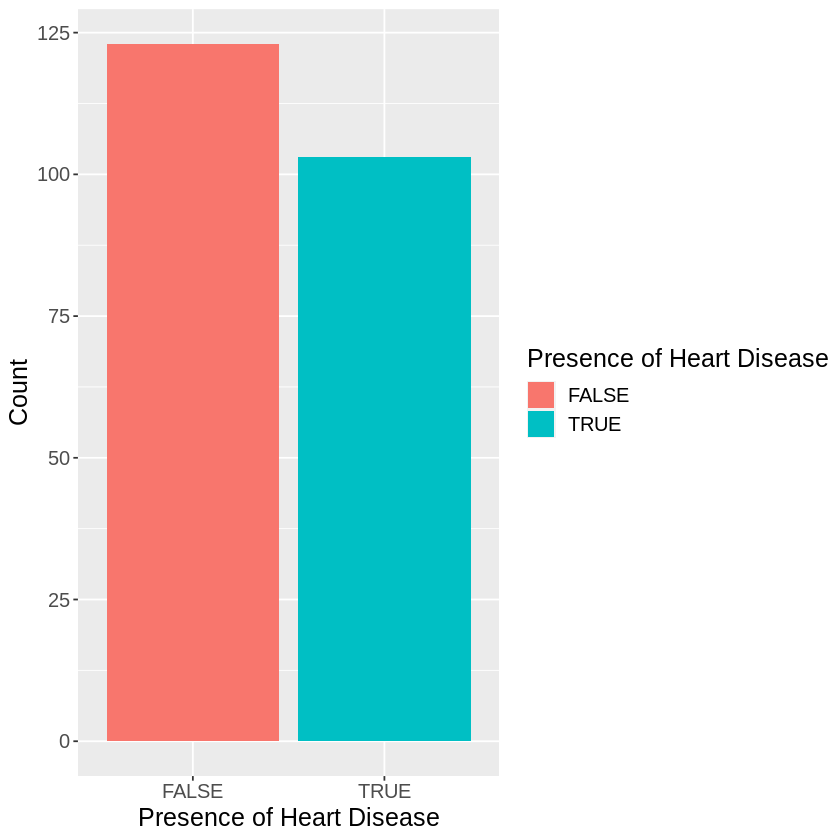

In [46]:
target_summary_plot <- target_summary |>
    ggplot(aes(x = presence, y = count, fill = presence)) +
    geom_bar(stat = "identity") +
    labs(x = "Presence of Heart Disease", y = "Count", fill = "Presence of Heart Disease") +
    theme(text = element_text(size = 15))

target_summary_plot
print("Figure 1: Summary of Presence (or not) of Heart Disease and how many patients")

From the dataset, the majority of patients do not have any presence of heart disease.

### Demographics

In [47]:
demographic_summary <- cleveland_training |>
    group_by(sex) |>
    summarize(count = n(), average_age = mean(age))
demographic_summary
print("Table 3: Presence of Heart Disease count for male (1) and female (0) patients, as well as average age of occurence")

sex,count,average_age
<fct>,<int>,<dbl>
0,73,56.06849
1,153,53.66667


[1] "Table 3: Presence of Heart Disease count for male (1) and female (0) patients, as well as average age of occurence"


[1] "Figure 2: Count of presence of Heart Disease in Male vs. Female patients"


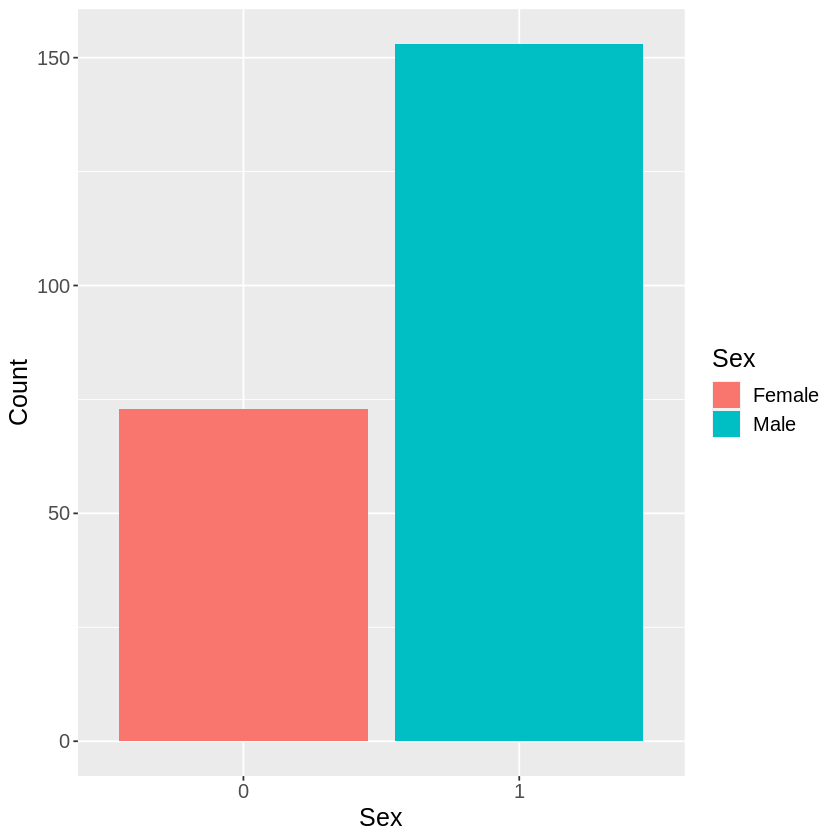

[1] "Figure 3: Count of presence of Heart Disease by age in Male and Femal patients"


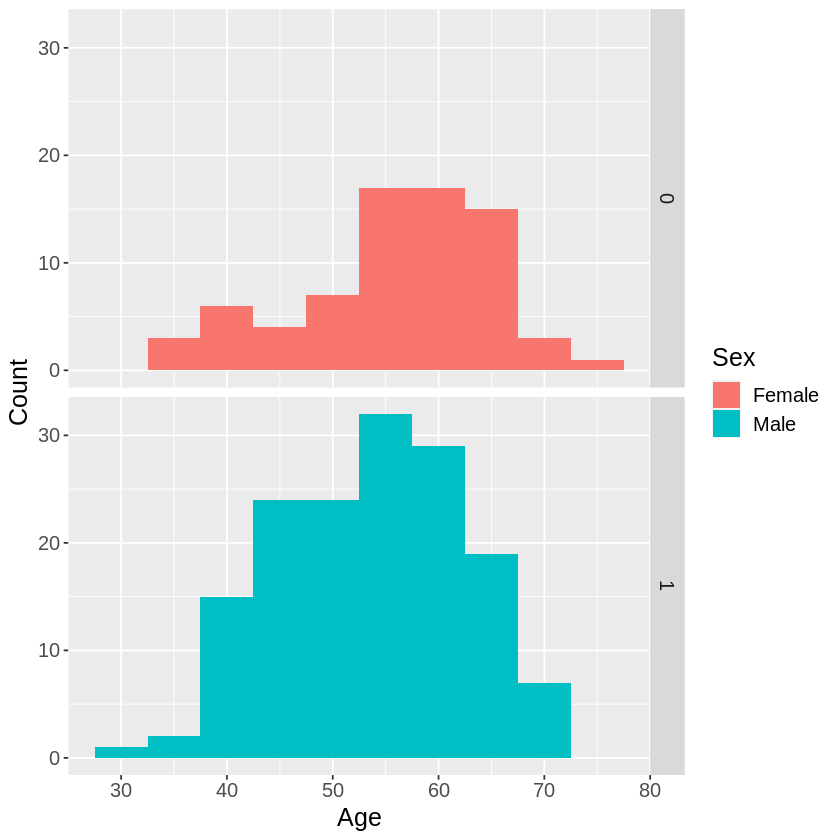

In [48]:
demographic_sex_summary_plot <- demographic_summary |>
    ggplot(aes(x =  sex, y = count, fill = sex)) +
    geom_bar(stat = "identity") +
    labs(x = "Sex", y = "Count", fill = "Sex") +
    scale_fill_discrete(labels = c("Female", "Male")) +
    theme(text = element_text(size = 15))

demographic_age_summary_plot <- cleveland_training |>
    ggplot(aes(x =  age, fill = sex)) +
    geom_histogram(binwidth = 5) +
    labs(x = "Age", y =  "Count", fill = "Sex") +
    scale_fill_discrete(labels = c("Female", "Male")) +
    facet_grid(rows = vars(sex)) +
    theme(text = element_text(size = 15))

demographic_sex_summary_plot
print("Figure 2: Count of presence of Heart Disease in Male vs. Female patients")
demographic_age_summary_plot
print("Figure 3: Count of presence of Heart Disease by age in Male and Femal patients")

The number of male double that of female participants. The average age for this dataset is around 54 years old. In addition, the average age of the male is slightly younger than female participants.

## Summary of Predicting Variables

### Maximum Heart Rate

In [49]:
average_thalach <- cleveland_training |>
    summarize(average_thalach = mean(thalach))

average_thalach_by_type <- cleveland_training |>
    group_by(presence) |>
    summarize(average_thalach = mean(thalach))
print(" Table 5.x - average Max Heart Rate within presence")  
average_thalach_by_type
print(" Table 5.x - average Max Heart Rate overall")  
average_thalach

presence,average_thalach
<fct>,<dbl>
FALSE,158.4309
TRUE,138.8058


average_thalach
<dbl>
149.4867


The average maximum heart rate achieved for this dataset is 149.5 *bpm*. Healthy people, on average, have much lower maximum heart rate compared to the sample population and the opposite is true for people with heart disease.

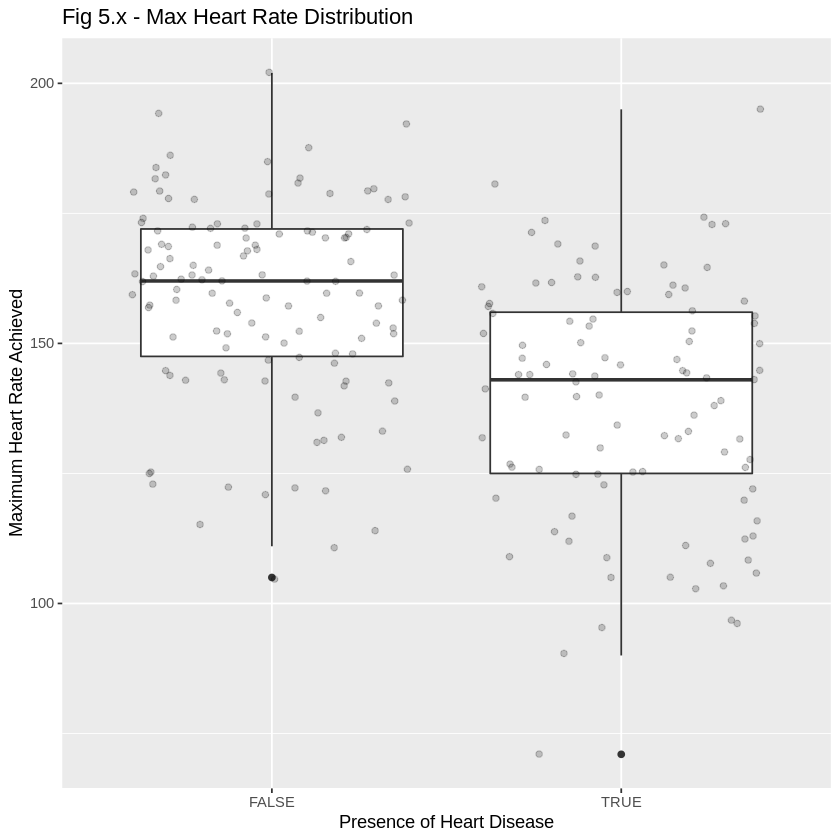

In [68]:
thalach_summary_plot <- cleveland_training |>
    ggplot(aes(x = presence, y = thalach)) +
    geom_boxplot() +
    geom_point(position = "jitter", alpha = 0.2) +
    labs(x = "Presence of Heart Disease", y = "Maximum Heart Rate Achieved")+ 
ggtitle("Fig 5.x - Max Heart Rate Distribution")

thalach_summary_plot

People who have presence of heart disease tend to have lower maximum heart rate achieved compared to people who don't. However, this time, the difference is a lot more significant, indicating a strong correlation. This is a good candidate predictor variable.

### ST Depression

In [67]:
average_oldpeak <- cleveland_training |>
    summarize(average_oldpeak = mean(oldpeak))

average_oldpeak_by_type <- cleveland_training |>
    group_by(presence) |>
    summarize(average_oldpeak = mean(oldpeak))
print(" Table 5.x - average ST Depression within presence")  
average_oldpeak_by_type
print(" Table 5.x - average ST Depression overall")  
average_oldpeak

[1] " Table 5.x - average ST Depression within presence"


presence,average_oldpeak
<fct>,<dbl>
FALSE,0.5910569
TRUE,1.5611650


[1] " Table 5.x - average ST Depression overall"


average_oldpeak
<dbl>
1.033186


From the dataset, the average ST depression is about 1*mm*. Healthy people have much lower ST depression compared to the sample population and the opposite is true for people with heart disease.

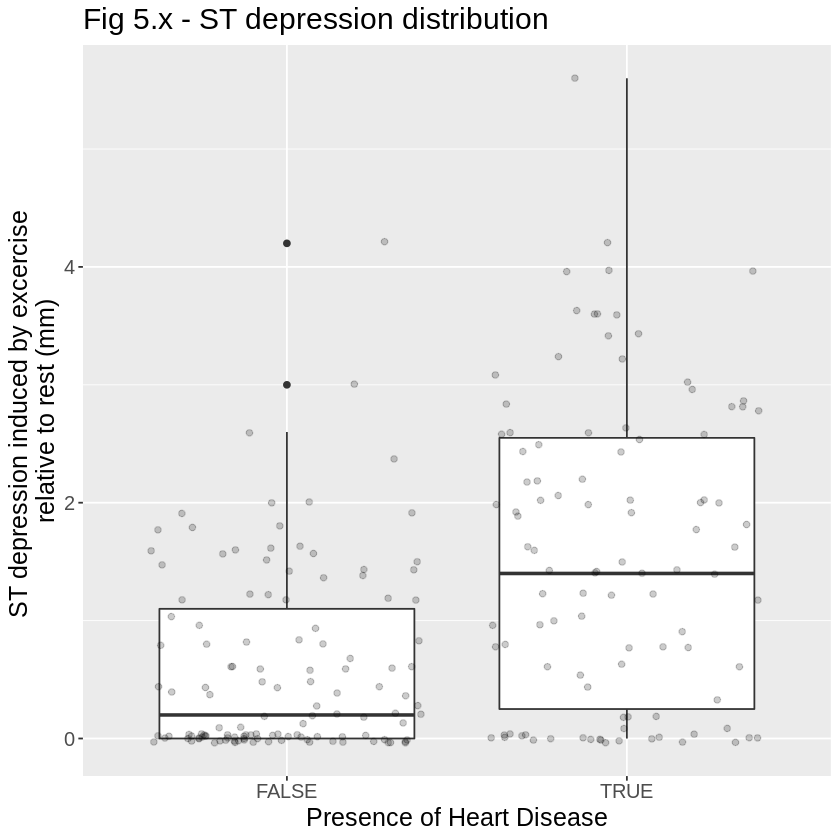

In [66]:
oldpeak_summary_plot <- cleveland_training |>
    ggplot(aes(x = presence, y = oldpeak)) +
    geom_boxplot() +
    geom_point(position = "jitter", alpha = 0.2) +
    labs(x = "Presence of Heart Disease",y = "ST depression induced by excercise \nrelative to rest (mm)") +
    theme(text = element_text(size = 15))+ggtitle("Fig 5.x - ST depression distribution")

oldpeak_summary_plot

Electrocardiography is the process of producing an electrocardiogram. It is a graph of voltage versus time of the electrical activity of the heart using electrodes placed on the skin. ST depression refers to a finding on an electrocardiogram, wherein the trace in the ST segment is abnormally low below the baseline. We can see that healthy people tend to don't or have ST depression less than 1*mm* compared to sick people. This is a very good candidate as a predictor variable.

## Methods

**Goal**: Predict the presence class (presence of heart disease) by using a $K$-nearest neighbor classification model and the most reliable predicting variables.
1. Tidy the data.
2. Split the data into training and testing datasets.
3. Group by presence of heart disease and summarise data to find the mean of each variable. 
4. Visualise with bar plots and boxplots to visualise how each mean is distributed and identify correlations. 
5. We will use the [maximum heart rate](#Maximum-Heart-Rate) and [oldpeak](#ST-Depression) as predicting variables because they show correlation to the diagnosis of heart disease. 
6. Choose the $K$ value that yields the highest accuracy and construct the final predicting model.
7. Evaluate this model to come to our conclusion.
8. Visualise our results by plotting our two predictor variables using a scatter plot and highlighting which areas represent diagnosis of heart disease and with a scatterplot of testing data on top to visually asess how our model performed.


### 6.1 Choosing Optimal K Value 

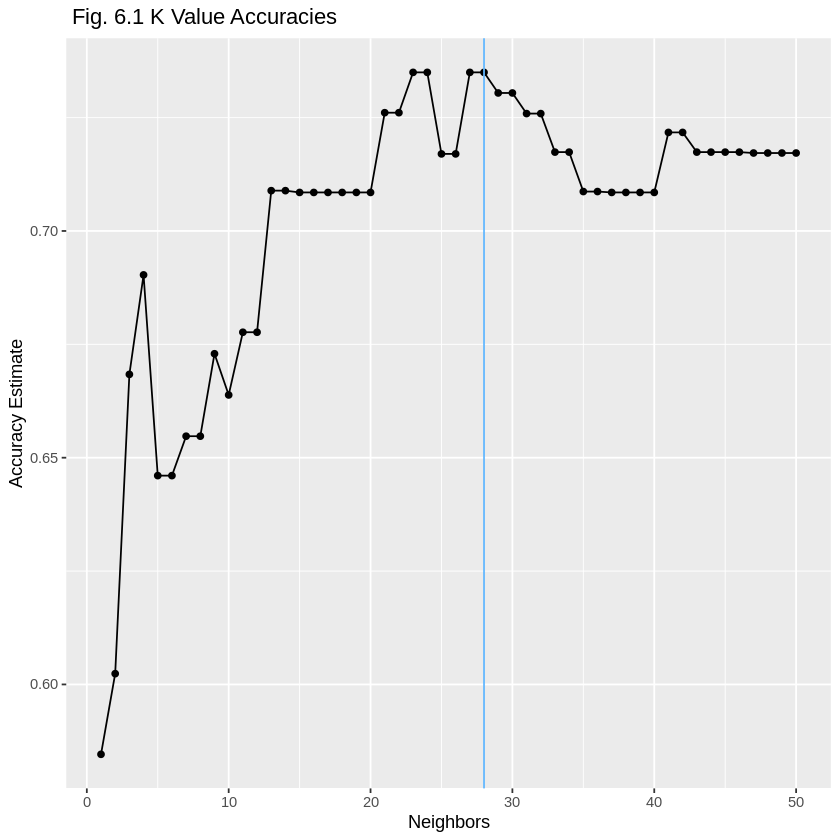

In [53]:
set.seed(8205)

knn_tune<-nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

training_recipe<-recipe(presence ~ thalach + oldpeak, data = cleveland_training)|>
    step_scale(all_predictors())|>
    step_center(all_predictors())

k_value<-tibble(neighbors = seq(from = 1, to = 50, by = 1))

training_fold<-vfold_cv(cleveland_training, v = 5, strata = presence)

training_results<-workflow()|>
    add_recipe(training_recipe)|>
    add_model(knn_tune)|>
    tune_grid(resamples = training_fold, grid = k_value)|>
    collect_metrics()

accuracies<-training_results|>
    filter(.metric == "accuracy")

cross_val_plot<-ggplot(accuracies, aes(x=neighbors, y=mean))+
    geom_point()+
    geom_line()+
     geom_vline(xintercept = 28, colour = "steelblue1") + 
    labs(x="Neighbors", y="Accuracy Estimate") + ggtitle(" Fig. 6.1 - K Value Accuracies") 
cross_val_plot


- The training set was tuned using cross validation (v = 5) to find an optimal K value. 
- The accuracy of each k value was plotted. 
- a range of k values of 1 to 50 was chosen to limit risk of overfitting. 
- We saw symmetry in our graph where the highest accuracy was found. The values with the highest accuracy were k = 23,24,27, and 28. 
- We have selected k=28 as the optimal value for our final KNN model because its surrounding k values accuracy did not decrease significantly compared to the surrounding k values of k = 23,24 and 27.

### 6.2 Build Final Model 

- new model build with workflow containing k = 28 

In [57]:
set.seed(8205)

cleveland_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 28) |>
       set_engine("kknn") |>
       set_mode("classification")

cleveland_fit <- workflow() |>
       add_recipe(training_recipe) |>
       add_model(cleveland_spec) |>
       fit(data = cleveland_training)
print("Figure 6.2 Final model")
cleveland_fit

[1] "Figure 6.2 Final model"


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(28,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2787611
Best kernel: rectangular
Best k: 28

## 7. Evaluate Final Model 

we can now evaluate the accuracy of our prediciting model against our testng set

In [62]:
set.seed(8205)

cleveland_predict<-predict(cleveland_fit, cleveland_testing)|>
    bind_cols(cleveland_testing)

cleveland_metrics<-cleveland_predict |>
    metrics(truth = presence, estimate = .pred_class)|>
    select(.metric, .estimate)
print("Table 7.1 Cleveland Metrics") 
cleveland_metrics

cleveland_confusion<-cleveland_predict|>
    conf_mat(truth = presence, estimate = .pred_class)
print("Table 7.2 Cleveland Confusion Matrix") 
cleveland_confusion

[1] "Table 7.1 Cleveland Metrics"


.metric,.estimate
<chr>,<dbl>
accuracy,0.7272727
kap,0.4437564


[1] "Table 7.2 Cleveland Confusion Matrix"


          Truth
Prediction FALSE TRUE
     FALSE    35   15
     TRUE      6   21

## Visualizaiton of data

- we wanted to visualize the areas on the graph that are assignet to the each diagnosis of heart disease 
- this was achieved by greating data points at every area on the graph and assigning them a prediction to highlight the blue (heart disease) and orange(no heart disease) areas 
- then we plotted these highlighting areas with the cleveland data to create a visual representation of where the predicting model failed to accuratlely predict the presence of heart disease

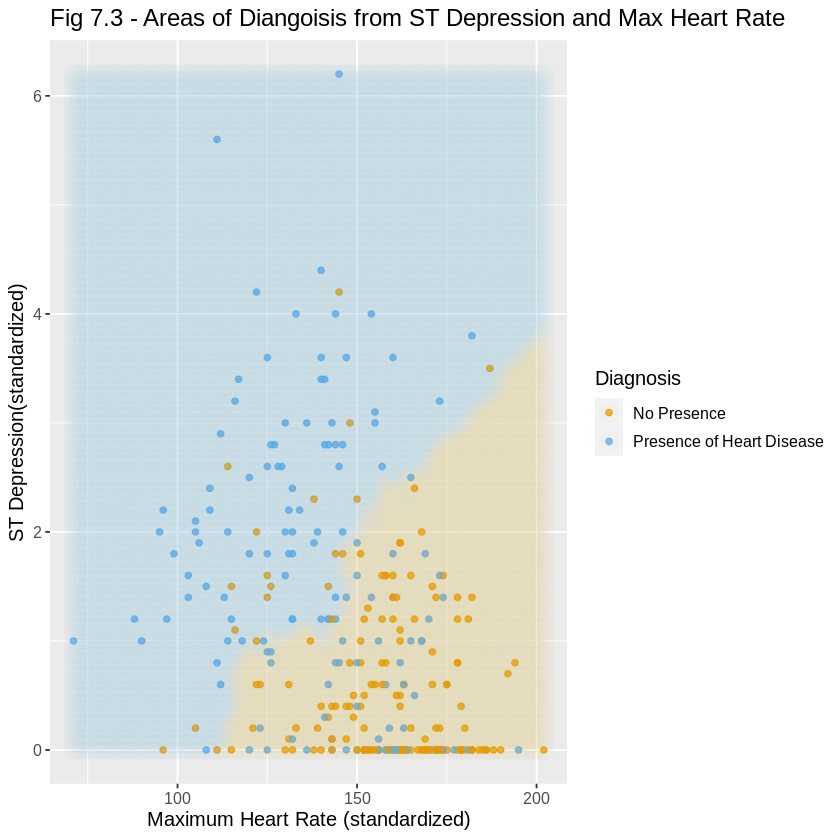

In [65]:
thalach_grid <- seq(from = min(cleveland_data$thalach), to = max(cleveland_data$thalach), length.out = 100)
oldpeak_grid <- seq(from = min(cleveland_data$oldpeak), to = max(cleveland_data$oldpeak), length.out = 100)

togrid <- as_tibble(expand.grid(thalach = thalach_grid, 
                                oldpeak = oldpeak_grid))

knnPredGrid <- predict(cleveland_fit, togrid)

prediction_table <- bind_cols(knnPredGrid, togrid) |> 
  rename(presence = .pred_class)

cleveland_vis <-
  ggplot() +
  geom_point(data = cleveland_data, 
             mapping = aes(x = thalach, 
                           y = oldpeak, 
                           color = presence), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = thalach, 
                           y = oldpeak, 
                           color = presence), 
             alpha = 0.02, 
             size = 5) +
  labs(color = "Diagnosis", 
       x = "Maximum Heart Rate (standardized)", 
       y = "ST Depression(standardized)") +
  scale_color_manual(labels = c("No Presence", "Presence of Heart Disease"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))+ ggtitle("Fig 7.3 - Areas of Diangoisis from ST Depression and Max Heart Rate") 

cleveland_vis

## Discussion

Our goal is to predict whether a patient has heart disease based on their basic medical information such as ST depression, blood pressure, serum cholesterol, maximum heart rate, *etc,.* We are expecting that if a patient’s testing result of a predictor variable, in our case, [maximum heart rate](#Maximum-Heart-Rate) and ST depression ([oldpeak](#ST-Depression)), falls into a specific range then the person is more likely to have heart disease. 

Such findings would lead to positive impacts on society because being able to predict the presence of heart disease with these variables could allow for early diagnosis. This could allow us to treat the disease as early as possible, before the disease becomes too harmful.  

Our findings could lead to some future questions, such as is there a specific range of maximum heart rate and ST depression that can predict the level of heart disease. Or are there other variables that are more accurate at predicting heart disease that are not present in this data set? Such a question requires further analysis of the data, and we would likely need a dataset consisting of more patient observations.
